# Flight Delay Analysis and Prediction
In recent years, delayed flights take up almost 20 percent in the total flights. Delayed flights influence the traveler's scheduals, so if we can make accurate predictions on the delay of the flights, it will help travelers for planning and enjoy their flights.  
In this project, we want to solve the flight delay prediction problem. To achieve our goal, we firstly collect our desired data from the  Bureau of Transportation Statistics and clean our data for the machine learning model and data analysis. Later, we do some analysis on the flights data and get some useful information from the analysis. Besides, we also use these meaningful information to do our feature encoding and feature selection. Furthermore, we choose some classifier models and regression models to train our data and use cross validation and grid search method to find the best parameters for each model. Finally we estimate the result we get and make a conclusion to our work and also leave some future work to improve the performance.
![avatar](./delay.jpg)  

## Catalog
<a href='#grab_data'>Grab the data</a>  
<a href='#load_data'>Load the data</a>  
<a href='#analyze_data'>Visualize and analyze the data</a>  
<a href='#Classifcation'>Predict serious delay appearance</a>  
<a href='#model_selection'>Select the models</a>  
<a href='#parameters_tuning'>Parameters tuning with Cross Validation and Grid Search</a>  
<a href='#conclusion'>Conclusion</a>  
<a href='#future_work'>Future work</a>  
<a href='#reference'>Reference</a>  

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
%matplotlib inline
import datetime, warnings, scipy 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")


import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import ensemble
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.grid_search import GridSearchCV

from sklearn import svm
from sklearn import neighbors

/Users/zeqiqiu/miniconda3/envs/py36/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/Users/zeqiqiu/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/zeqiqiu/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be rem

<a id='grab_data'></a>
# 1. Grab the data

We need to solve the flight delay prediction problem, so we need to gather enough flights data and the data relted to it. In this case, we find [The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics](https://www.bts.gov/). The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics tracks the on-time performance of domestic flights operated by large air carriers. It has several huge database which contains abundant flights informations, for example each year, each month, each day and each flight's airline, original airport, destination airport, departure time, schedualed departure time, arrival time and schedualed arrival time and so on. The stastistic in this website is abundant and contain enough important information for our predictions. Besides, it contains too much kinds of data, so we have to determine which data do we need.  
![avatar](./mainpage.jpeg)  
In order to grab the data from the Bureau of Transportation Statistics website, we write an API to interact with the website and gather our desired data from the website. Firstly, we use the selenium library to interact with the website. Besides, we write an html parser which parse the desired data from the html files we got from the interactions. Furthermore, we clean the data by replacing the NAN value for some columns and filter some lines still with NAN in the end. Finally, we store the data to the csv file for our following analysis, model training and predictions. The data we store default is in "./data/", you can change the store_path for your desired path.  
In this project, we only deal with the flight data date from 03/2017 to 02/2018. Besides, we only deal with the flights which original airport or destination airport is in Pennsylvania.

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from time import sleep
import os
import shutil
import zipfile
import pandas as pd

store_path="./data"

In [3]:
"""
Post the province information to the website in order to get the data from this province,
for example get_province('California') will get the data in Califoria
"""
def get_province(driver,province):
    element=driver.find_element_by_name("GEOGRAPHY")
    element.send_keys(province)

In [4]:
"""
Post the year information to the website in order to get the data from this year,
for example get_year(2018) will get the data in 2018
"""
def get_year(driver,year):
    element=driver.find_element_by_name("XYEAR")
    element.send_keys(year)

In [5]:
"""
Post the month information to the website in order to get the data from this month,
for example get_month(1) will get the data in January
"""
def get_month(driver,month):
    months = ["Unknown","January","Febuary","March","April","May","June","July","August","September","October",
              "November","December"]
    element=driver.find_element_by_name("FREQUENCY")
    element.send_keys(months[month])

In [6]:
"""
click download in the website to get some row data
"""
def click_download(driver):
    element=driver.find_element_by_name("Download")
    element.click()
    sleep(10)
    filelist = os.listdir(store_path)
    if len(filelist)==0:
        return
    filelist.sort(key=lambda f:os.path.getmtime(store_path+'/'+f))
    filepath = os.path.join(store_path,filelist[-1])
    zip_ref = zipfile.ZipFile(filepath, 'r')
    zip_ref.extractall(store_path)
    zip_ref.close()
    os.remove(filepath)
    filelist = os.listdir(store_path)
    filelist.sort(key=lambda f:os.path.getmtime(store_path+'/'+f))
    filepath = os.path.join(store_path,filelist[-1])
    return filepath
#     shutil.move(os.path.join(store_path,filename),"downloadfile")

In [7]:
"""
choose the information we want like year,month,origin airport,destination airport and so on.
"""
def get_clicked(driver):
    driver.find_element_by_xpath('//input[@value="YEAR"]').click()
    driver.find_element_by_xpath('//input[@value="MONTH"]').click()
    driver.find_element_by_xpath('//input[@value="DAY_OF_MONTH"]').click()
    driver.find_element_by_xpath('//input[@value="DAY_OF_WEEK"]').click()
    driver.find_element_by_xpath('//input[@value="CARRIER"]').click()
    driver.find_element_by_xpath('//input[@value="TAIL_NUM"]').click()
    driver.find_element_by_xpath('//input[@value="FL_NUM"]').click()
    driver.find_element_by_xpath('//input[@value="ORIGIN"]').click()
    driver.find_element_by_xpath('//input[@value="DEST"]').click()
    driver.find_element_by_xpath('//input[@value="CRS_DEP_TIME"]').click()
    driver.find_element_by_xpath('//input[@value="DEP_TIME"]').click()
    driver.find_element_by_xpath('//input[@value="DEP_DELAY"]').click()
    driver.find_element_by_xpath('//input[@value="CRS_ARR_TIME"]').click()
    driver.find_element_by_xpath('//input[@value="ARR_TIME"]').click()
    driver.find_element_by_xpath('//input[@value="ARR_DELAY"]').click()
    driver.find_element_by_xpath('//input[@value="CANCELLED"]').click()
    driver.find_element_by_xpath('//input[@value="CRS_ELAPSED_TIME"]').click()
    driver.find_element_by_xpath('//input[@value="ACTUAL_ELAPSED_TIME"]').click()
    driver.find_element_by_xpath('//input[@value="DISTANCE"]').click()
    driver.find_element_by_xpath('//input[@value="CARRIER_DELAY"]').click()
    driver.find_element_by_xpath('//input[@value="WEATHER_DELAY"]').click()
    driver.find_element_by_xpath('//input[@value="NAS_DELAY"]').click()
    driver.find_element_by_xpath('//input[@value="SECURITY_DELAY"]').click()
    driver.find_element_by_xpath('//input[@value="LATE_AIRCRAFT_DELAY"]').click()

In [8]:
def get_data(driver,province,year,month):
    get_province(driver,province)
    get_year(driver,year)
    get_month(driver,month)

In [9]:
"""
script for grabbing the data, we need to deliver a path for the row data download from the website, and a list
of target provinces and a list of year and date pair.
"""
def script(downloadfilepath,province=["Pennsylvania"],date=[(2018,2)]):
    chrome_options = webdriver.ChromeOptions() 
    preferences = {"download.default_directory":downloadfilepath,
               "directory_upgrade": True,
               "safebrowsing.enabled": True }
#     options.add_argument("download.default_directory="+downloadfilepath)
    chrome_options.add_experimental_option("prefs", preferences)
    driver = webdriver.Chrome(executable_path=r'/Users/zeqiqiu/Downloads/chromedriver',chrome_options=chrome_options)
    model_DF=pd.DataFrame()
    column_names=['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CARRIER', 'TAIL_NUM',
       'FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID',
       'ORIGIN_CITY_MARKET_ID', 'ORIGIN', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'CRS_DEP_TIME',
       'DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DISTANCE',
       'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
       'LATE_AIRCRAFT_DELAY']
    for p in province:
        for day in date:
            y=day[0]
            m=day[1]
            if y==2018 and m>=3:
                continue
            driver.get('https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236')
            get_clicked(driver)
#                 print("finish clicked")
            get_data(driver,p,y,m)
#                 print("finish get data")
            fname=click_download(driver)
#                 print("finish download")
            name=str(p)+"_"+str(y)+"_"+str(m)+".csv"
            newname=os.path.join(store_path,name)
            os.rename(fname,newname)
            print(newname)
            df = pd.read_csv(newname,usecols=column_names)
            df["CARRIER_DELAY"]=df["CARRIER_DELAY"].fillna(value=0)
            df["WEATHER_DELAY"]=df["WEATHER_DELAY"].fillna(value=0)
            df["NAS_DELAY"]=df["NAS_DELAY"].fillna(value=0)
            df["SECURITY_DELAY"]=df["SECURITY_DELAY"].fillna(value=0)
            df["LATE_AIRCRAFT_DELAY"]=df["LATE_AIRCRAFT_DELAY"].fillna(value=0)
            df = df.dropna()
            print(df.shape)
            model_DF=pd.concat([model_DF,df])        
    return model_DF

In [10]:
"""
We deal with the data for one year from 3/2017 to 2/2018
"""
model_DF=script("./data",date=[(2018,2),(2018,1),(2017,12)
                                ,(2017,11),(2017,10),(2017,9)
                                ,(2017,8),(2017,7),(2017,6)
                                ,(2017,5),(2017,4),(2017,3)])
model_DF
model_DF.to_csv("combined_data.csv", sep='\t')

./data/Pennsylvania_2018_2.csv
(25155, 30)
./data/Pennsylvania_2018_1.csv
(26207, 30)
./data/Pennsylvania_2017_12.csv
(18149, 30)
./data/Pennsylvania_2017_11.csv
(18299, 30)
./data/Pennsylvania_2017_10.csv
(18812, 30)
./data/Pennsylvania_2017_9.csv
(17922, 30)
./data/Pennsylvania_2017_8.csv
(19771, 30)
./data/Pennsylvania_2017_7.csv
(19770, 30)
./data/Pennsylvania_2017_6.csv
(19043, 30)
./data/Pennsylvania_2017_5.csv
(19030, 30)
./data/Pennsylvania_2017_4.csv
(18152, 30)
./data/Pennsylvania_2017_3.csv
(18311, 30)


<a id='load_data'></a>
## 2. Loading data and categorize the columns
We load the data to the dataframe df. Here follows the columns of the data, the type and their meanings.


|          Name          | Type | DESCRIPTION |
|-------------|-------------|-------------|
|YEAR              |         int64|Year|
|MONTH               |       int64|Month 1-12|
|DAY_OF_MONTH       |        int64|The day of the month |
|DAY_OF_WEEK        |        int64|Monday to Sunday|
|CARRIER            |       object|Airline|
|TAIL_NUM           |       object|Tail number of the flight|
|FL_NUM             |        int64|Flight number|
|ORIGIN_AIRPORT_ID     |     int64|The code for origin airport |
|ORIGIN_AIRPORT_SEQ_ID  |    int64|The SEQ_ID for origin airport |
|ORIGIN_CITY_MARKET_ID  |    int64|The Market ID for origin airport |
|ORIGIN           |         object|The origin Airport|
|DEST_AIRPORT_ID       |     int64|The code for destination airport |
|DEST_AIRPORT_SEQ_ID   |     int64|The SEQ_ID for destination airport |
|DEST_CITY_MARKET_ID   |     int64|The Market ID for destination airport |
|DEST                  |    object|The destination Airport|
|CRS_DEP_TIME        |       int64|Schedualed departure time|
|DEP_TIME            |     float64|Actual departure time|
|DEP_DELAY          |      float64|Delay of the departure|
|CRS_ARR_TIME      |         int64|Schedualed arrival time|
|ARR_TIME          |       float64|Actual arrival time|
|ARR_DELAY         |       float64|Delay of the arrival  (**our prediction target)|
|CANCELLED         |       float64|Flight Cancled|
|CRS_ELAPSED_TIME   |      float64|Schedualed flying time|
|ACTUAL_ELAPSED_TIME  |    float64|Actual flying time|
|DISTANCE           |      float64|Distance|
|CARRIER_DELAY      |      float64|Airline delay|
|WEATHER_DELAY      |      float64|Delay for the weather reason|
|NAS_DELAY          |      float64|NAS delay|
|SECURITY_DELAY     |      float64|Sequrity_DELAY|
|LATE_AIRCRAFT_DELAY|      float64|What part of the delay is due to previous flight(s) being late(mins) |




In [11]:
df = pd.read_csv('combined_data.csv',sep='\t')
df = df.drop(columns=['Unnamed: 0'])
df.dropna(how="any", inplace=True)
# Generate DELAY_OR_NOT column & select only relevant variables

df.head(10)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2018,2,4,7,DL,N905DE,1895,14100,1410005,34100,PHL,10397,1039707,30397,ATL,1312,1309.0,-3.0,1536,1523.0,-13.0,0.0,144.0,134.0,666.0,0.0,0.0,0.0,0.0,0.0
1,2018,2,4,7,DL,N906DA,1900,14100,1410005,34100,PHL,13487,1348702,31650,MSP,830,827.0,-3.0,1038,1019.0,-19.0,0.0,188.0,172.0,980.0,0.0,0.0,0.0,0.0,0.0
2,2018,2,4,7,DL,N910AT,1960,13487,1348702,31650,MSP,14100,1410005,34100,PHL,1125,1121.0,-4.0,1506,1506.0,0.0,0.0,161.0,165.0,980.0,0.0,0.0,0.0,0.0,0.0
3,2018,2,4,7,DL,N915AT,1960,14100,1410005,34100,PHL,13487,1348702,31650,MSP,1640,1642.0,2.0,1846,1830.0,-16.0,0.0,186.0,168.0,980.0,0.0,0.0,0.0,0.0,0.0
4,2018,2,4,7,DL,N905DL,2023,14100,1410005,34100,PHL,11433,1143302,31295,DTW,915,909.0,-6.0,1114,1054.0,-20.0,0.0,119.0,105.0,453.0,0.0,0.0,0.0,0.0,0.0
5,2018,2,4,7,DL,N907DL,2036,10397,1039707,30397,ATL,14100,1410005,34100,PHL,1630,1705.0,35.0,1835,1904.0,29.0,0.0,125.0,119.0,666.0,0.0,0.0,29.0,0.0,0.0
6,2018,2,4,7,DL,N956AT,2081,13487,1348702,31650,MSP,14122,1412202,30198,PIT,1515,1506.0,-9.0,1816,1801.0,-15.0,0.0,121.0,115.0,726.0,0.0,0.0,0.0,0.0,0.0
7,2018,2,4,7,DL,N996AT,2157,11433,1143302,31295,DTW,14100,1410005,34100,PHL,2020,2020.0,0.0,2210,2221.0,11.0,0.0,110.0,121.0,453.0,0.0,0.0,0.0,0.0,0.0
8,2018,2,4,7,DL,N901DE,2161,10397,1039707,30397,ATL,14122,1412202,30198,PIT,810,808.0,-2.0,949,932.0,-17.0,0.0,99.0,84.0,526.0,0.0,0.0,0.0,0.0,0.0
9,2018,2,4,7,DL,N986DL,2290,14122,1412202,30198,PIT,10397,1039707,30397,ATL,600,550.0,-10.0,800,751.0,-9.0,0.0,120.0,121.0,526.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# for the regression models
df_regress=df.copy()

First we classifed the data simply into two categories, i.e., whether the delay is above thirty minutes or not. Then we created a new column named 'DELAY_APPEAR' to store the new classification data.

In [13]:
df['DELAY_APPEAR'] = np.where(df['ARR_DELAY'] >= 30, 1, 0)
numerical = ['CRS_DEP_TIME','CRS_ARR_TIME','DEP_DELAY','CRS_ELAPSED_TIME']
categorical = ['MONTH','DAY_OF_MONTH','DAY_OF_WEEK','CARRIER','ORIGIN','DEST']
df.head(10)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DELAY_APPEAR
0,2018,2,4,7,DL,N905DE,1895,14100,1410005,34100,PHL,10397,1039707,30397,ATL,1312,1309.0,-3.0,1536,1523.0,-13.0,0.0,144.0,134.0,666.0,0.0,0.0,0.0,0.0,0.0,0
1,2018,2,4,7,DL,N906DA,1900,14100,1410005,34100,PHL,13487,1348702,31650,MSP,830,827.0,-3.0,1038,1019.0,-19.0,0.0,188.0,172.0,980.0,0.0,0.0,0.0,0.0,0.0,0
2,2018,2,4,7,DL,N910AT,1960,13487,1348702,31650,MSP,14100,1410005,34100,PHL,1125,1121.0,-4.0,1506,1506.0,0.0,0.0,161.0,165.0,980.0,0.0,0.0,0.0,0.0,0.0,0
3,2018,2,4,7,DL,N915AT,1960,14100,1410005,34100,PHL,13487,1348702,31650,MSP,1640,1642.0,2.0,1846,1830.0,-16.0,0.0,186.0,168.0,980.0,0.0,0.0,0.0,0.0,0.0,0
4,2018,2,4,7,DL,N905DL,2023,14100,1410005,34100,PHL,11433,1143302,31295,DTW,915,909.0,-6.0,1114,1054.0,-20.0,0.0,119.0,105.0,453.0,0.0,0.0,0.0,0.0,0.0,0
5,2018,2,4,7,DL,N907DL,2036,10397,1039707,30397,ATL,14100,1410005,34100,PHL,1630,1705.0,35.0,1835,1904.0,29.0,0.0,125.0,119.0,666.0,0.0,0.0,29.0,0.0,0.0,0
6,2018,2,4,7,DL,N956AT,2081,13487,1348702,31650,MSP,14122,1412202,30198,PIT,1515,1506.0,-9.0,1816,1801.0,-15.0,0.0,121.0,115.0,726.0,0.0,0.0,0.0,0.0,0.0,0
7,2018,2,4,7,DL,N996AT,2157,11433,1143302,31295,DTW,14100,1410005,34100,PHL,2020,2020.0,0.0,2210,2221.0,11.0,0.0,110.0,121.0,453.0,0.0,0.0,0.0,0.0,0.0,0
8,2018,2,4,7,DL,N901DE,2161,10397,1039707,30397,ATL,14122,1412202,30198,PIT,810,808.0,-2.0,949,932.0,-17.0,0.0,99.0,84.0,526.0,0.0,0.0,0.0,0.0,0.0,0
9,2018,2,4,7,DL,N986DL,2290,14122,1412202,30198,PIT,10397,1039707,30397,ATL,600,550.0,-10.0,800,751.0,-9.0,0.0,120.0,121.0,526.0,0.0,0.0,0.0,0.0,0.0,0


<a id='analyze_data'></a>
## 3. Visualize  and analyze the data

We got global statistics from the delay data of various airlines, and found out that the results between different carriers varied a lot.The mean delay and highest outlier of EV airline are both higher than others. Though under the circumstances that the sample is quite large, UA and DL maintain a negative mean value, which means arrive earlier than the estimated time, i.e., a satisfying arrial results.

In [14]:
def stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
stats = df['ARR_DELAY'].groupby(df['CARRIER']).apply(stats).unstack()
stats = stats.sort_values('count')
stats

,count,max,mean,min
CARRIER,,,,
G4,669.0,331.0,5.829596,-66.0
VX,698.0,126.0,-8.931232,-64.0
AS,921.0,227.0,-13.337676,-70.0
MQ,1013.0,409.0,7.587364,-39.0
YV,1412.0,1287.0,0.347025,-49.0
9E,1745.0,1042.0,3.582808,-57.0
OH,3639.0,865.0,11.864798,-43.0
EV,5668.0,1810.0,15.810868,-50.0
YX,8285.0,596.0,1.585154,-57.0


Next, we used heatmap to print out the correlation between different variables. Before plotting the heatmap, we removed those unrelated variables like 'CANCELLED', 'YEAR' and 'MONTH'. For the variable we need to predict, 'ARR_DELAY', we looked into the correlations between this variable and others. Then we selected correlation values that are above 0.5, and chose the corresponding variables including 'DEP_DELAY', 'CARRIER_DELAY' and 'LATE_AIRCRAFT_DELAY' as the focus variables because we knew they have a closer relationship with arrival delay.

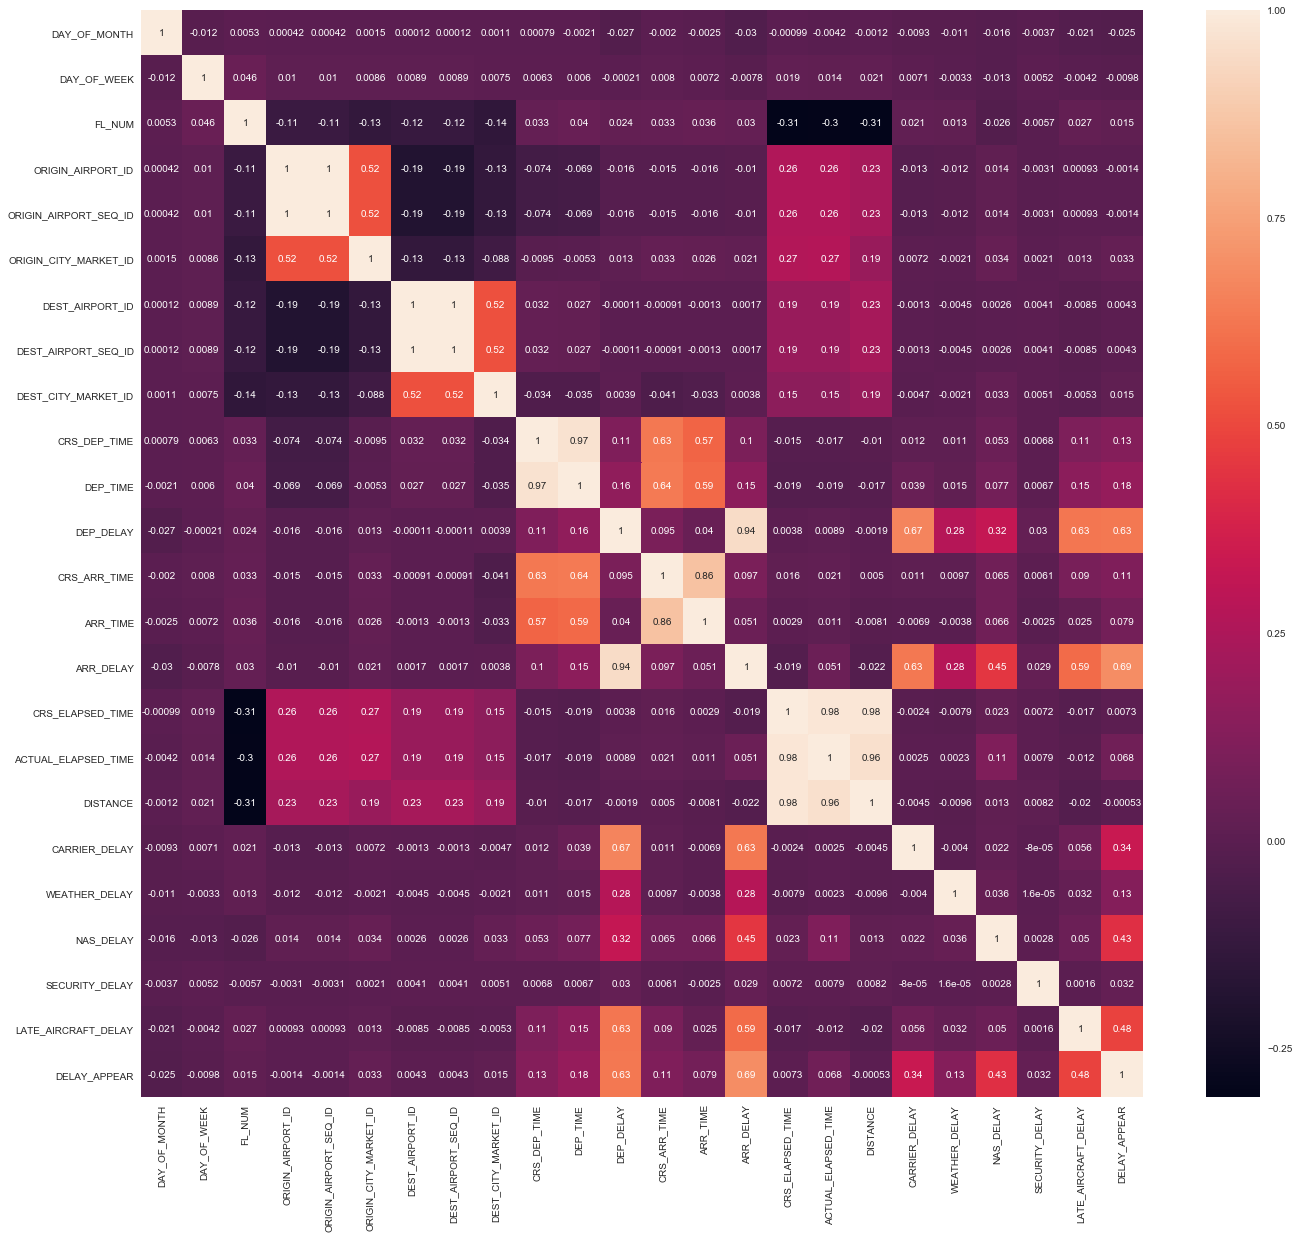

In [15]:
df2 =df.copy()
df2 = df2.drop(['CANCELLED'], axis = 1)
df2 = df2.drop(['YEAR'], axis = 1)
df2 = df2.drop(['MONTH'], axis = 1)
fig,ax = plt.subplots(nrows =1, ncols = 1, figsize = (20,20))
corr = df2.corr()
sns.heatmap(corr, annot = True)

Though delay is a common situation, the level of acceptance for different duration of delay can vary greatly. Thus, we classified the delay into three different types, small delay for those within 10 minutes, medium delay for those between 10 minutes and 30 minutes, and large delay for those over 30 minutes. We created a new column 'DELAY_LEVEL' to store the results and used a countplot to show the total numbers of different delays for various carriers.

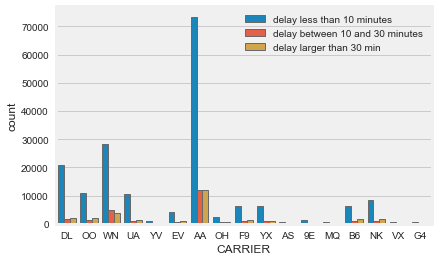

In [16]:
def level(delay):
    if delay < 10:
        return 0
    elif delay <30:
        return 1
    else:
        return 2
df['DELAY_LEVEL'] = df['ARR_DELAY'].apply(lambda x: level(x))
fig = plt.figure()
ax = sns.countplot(x="CARRIER", hue='DELAY_LEVEL', data=df)
L = plt.legend()
L.get_texts()[0].set_text('delay less than 10 minutes')
L.get_texts()[1].set_text('delay between 10 and 30 minutes')
L.get_texts()[2].set_text('delay larger than 30 min')


We used the stripplot to make a census of all the delays that were measured in 2018 Pennsylvania. The figure shows intensive scatter on the left side, which means that most of the delays are within 2 hours. However, we can see that there are some discrete spots on the right side, illustraing some large delays could reach over 10 hours.

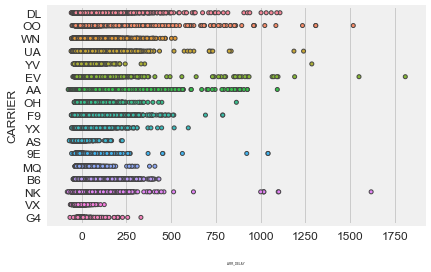

In [17]:
df2 = df.loc[:, ['CARRIER', 'ARR_DELAY']]
ax3 = sns.stripplot(y="CARRIER", x="ARR_DELAY", size = 4, data=df2, linewidth = 1)
fig = plt.figure(1, figsize=(15,10))
plt.setp(ax3.get_xticklabels(), fontsize=12)
plt.setp(ax3.get_yticklabels(), fontsize=12)
plt.xlabel('ARR_DELAY', fontsize=3, labelpad=20)
ax3.yaxis.label.set_visible(True)

We displayed the relationship between the arrival delay distribution and both the airport and aircraft type. In the figure we can see that most airplanes at the PHL and PIT airports are suffered from short delay, and some of the airplanes ar the DTW and AVP airport have serious delays.

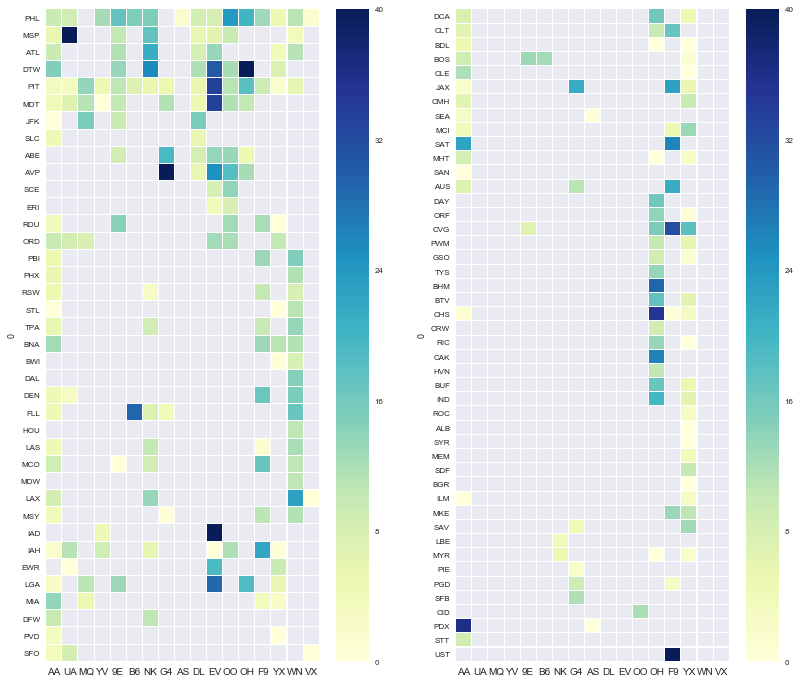

In [18]:
def stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
avg_delay = pd.DataFrame(pd.Series(df['ORIGIN'].unique()))
avg_delay.set_index(0, drop = True, inplace = True)
for carrier in set(df['CARRIER']):
    fg1 = df[df['CARRIER'] == carrier]
    test = fg1['DEP_DELAY'].groupby(df['ORIGIN']).apply(stats).unstack()
    avg_delay[carrier] = test.loc[:, 'mean']

sns.set(context="paper")
fig = plt.figure(1, figsize=(12,12))
ax = fig.add_subplot(1,2,1)
subset = avg_delay.iloc[:38,:].rename(columns = df['CARRIER'])
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.05, cmap="YlGnBu", mask=mask, vmin = 0, vmax = 40)
plt.setp(ax.get_xticklabels(), fontsize=10) ;
ax = fig.add_subplot(1,2,2)    
subset = avg_delay.iloc[39:100,:].rename(columns = df['CARRIER'])
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.05, cmap="YlGnBu", mask=mask, vmin = 0, vmax = 40)
plt.setp(ax.get_xticklabels(), fontsize=10) ;



<a id='model_selection'></a>
## 4. Classifcation


In [19]:
df = df[categorical+ numerical + ['DELAY_APPEAR']]
df = pd.get_dummies(df, columns=categorical, drop_first=True)
#np.random.seed(1)
# split data into 5% training & test, 95% validation
model_df, validation_df = train_test_split(df, train_size=0.1)

train_df, test_df = train_test_split(model_df, train_size=0.8)


In [20]:
X_train = train_df.loc[:, train_df.columns != 'DELAY_APPEAR']
y_train = train_df['DELAY_APPEAR']
X_test = test_df.loc[:, test_df.columns != 'DELAY_APPEAR']
y_test = test_df['DELAY_APPEAR']
X_validation = validation_df.loc[:, validation_df.columns != 'DELAY_APPEAR']
y_validation = validation_df['DELAY_APPEAR']

In [21]:
# Logistic Regression
logitm = LogisticRegression(C=10000)
logitm.fit(X_train, y_train)

print("LR Train Accuracy: ", logitm.score(X_train, y_train))
print("LR Test Accuracy: ", logitm.score(X_test, y_test))

LR Train Accuracy:  0.9557336686049558
LR Test Accuracy:  0.9606117745652629


In [22]:
# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

print('LDA Train Accuracy: ', lda.score(X_train, y_train))
print('LDA Test Accuracy: ', lda.score(X_test, y_test))

LDA Train Accuracy:  0.9386033841479386
LDA Test Accuracy:  0.9358893777498428


In [23]:
# SVM
from sklearn import svm
svm = svm.SVC()
svm.fit(X_train, y_train)

print('SVM Train Accuracy: ', svm.score(X_train, y_train))
print('SVM Test Accuracy: ', svm.score(X_test, y_test))

SVM Train Accuracy:  0.9734402011629735
SVM Test Accuracy:  0.9082338152105593


In [24]:
# kNN
max_score = 0
best_k = 0 

for k in range(1,20):
    knn = KNeighborsClassifier(n_neighbors = k)
    score = cross_val_score(knn,X_train, y_train).mean()
    if score > max_score:
        best_k = k
        max_score = score
 
knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(X_train, y_train)

print('KNN Train Accuracy:', knn.score(X_train, y_train))
print('KNN Test Accuracy:', knn.score(X_test, y_test))


KNN Train Accuracy: 0.9560479857509561
KNN Test Accuracy: 0.9444793630840143


<a id='model_selection'></a>
## 5. Model Selection 
From the analysis above, we select some features which have high correlation with our target label(ARRIVAL_DELAY). In this section, we will choose some models to train and use these models for our prediction.  
Firstly, we make up a new dataframe with some features we choose. We select the columns 'CRS_DEP_TIME','DEP_TIME','DEP_DELAY','CRS_ARR_TIME','CARRIER_DELAY',
        'WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY' as our features.  
Then, we split our data into two dataset, one is for training and validation and the other is for testing. The ration of the seperation is 0.2.

In [28]:
from sklearn import svm
labels=df_regress["ARR_DELAY"].values
print(labels)
data=df_regress[['CRS_DEP_TIME','DEP_TIME','DEP_DELAY','CRS_ARR_TIME','CARRIER_DELAY',
        'WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']].values
print(data)

[-13. -19.   0. ...   7.  -4.  -1.]
[[1312. 1309.   -3. ...    0.    0.    0.]
 [ 830.  827.   -3. ...    0.    0.    0.]
 [1125. 1121.   -4. ...    0.    0.    0.]
 ...
 [1325. 1342.   17. ...    0.    0.    0.]
 [ 804.  754.  -10. ...    0.    0.    0.]
 [1810. 1810.    0. ...    0.    0.    0.]]


In [29]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, labels ,test_size=0.2)

In [30]:
svr_model = svm.SVR(verbose=True,max_iter=60000)
svr_model.fit(X_train,y_train)
svr_prediction = svr_model.predict(X_test)
print(mean_absolute_error(svr_prediction,y_test))
print(svr_prediction)
print(y_test)

[LibSVM]20.194719825671843
[ -8.75457669  -3.81276227  -7.83488635 ...  -6.29119502 -10.03383483
  -6.72227969]
[  5.  -8. -19. ...  -4. -10. -20.]


In [31]:
knn_model = neighbors.KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train,y_train)
knn_prediction = knn_model.predict(X_test)
print(mean_absolute_error(knn_prediction,y_test))
print(svr_prediction)
print(y_test)

8.087354635935045
[ -8.75457669  -3.81276227  -7.83488635 ...  -6.29119502 -10.03383483
  -6.72227969]
[  5.  -8. -19. ...  -4. -10. -20.]


In [32]:
xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb_model.fit(X_train,y_train)
xgb_prediction = xgb_model.predict(X_test)
print(mean_absolute_error(xgb_prediction,y_test))
print(xgb_prediction)
print(y_test)

6.818631357996797
[-13.8310995  -9.231789   -9.797683  ...  -8.335138   -9.326603
 -13.961936 ]
[  5.  -8. -19. ...  -4. -10. -20.]


In [33]:
randomforest_model =ensemble.RandomForestRegressor(n_estimators=100)
randomforest_model.fit(X_train,y_train)
randomforest_prediction = randomforest_model.predict(X_test)
print(mean_absolute_error(randomforest_prediction,y_test))
print(randomforest_prediction)
print(y_test)

6.911376517560476
[-10.02962302  -5.38002381 -14.48096032 ...  -1.89431746  -7.73120779
 -19.62027706]
[  5.  -8. -19. ...  -4. -10. -20.]


From the testing error above for each models, we can see that knn, Xgboost and random forest get very good results and very low errors. The figure below shows the error for these four models and we can find that Xgboost get the best result in predicting the flight delay. In the next section, we will choose the three good models here to tune the parameters in order to get a better performance.

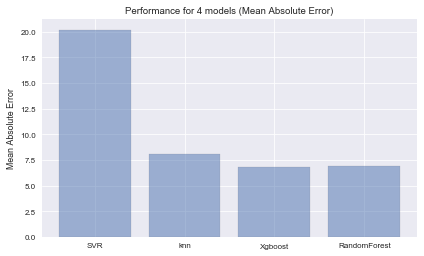

In [34]:
models = ('SVR','knn','Xgboost','RandomForest')
y_pos = np.arange(len(models))
mean_absolute_errors=[mean_absolute_error(svr_prediction,y_test),mean_absolute_error(knn_prediction,y_test),
                     mean_absolute_error(xgb_prediction,y_test),mean_absolute_error(randomforest_prediction,y_test)]
 
plt.bar(y_pos, mean_absolute_errors, align='center', alpha=0.5)
plt.xticks(y_pos, models)
plt.ylabel('Mean Absolute Error')
plt.title('Performance for 4 models (Mean Absolute Error)')
 
plt.show()

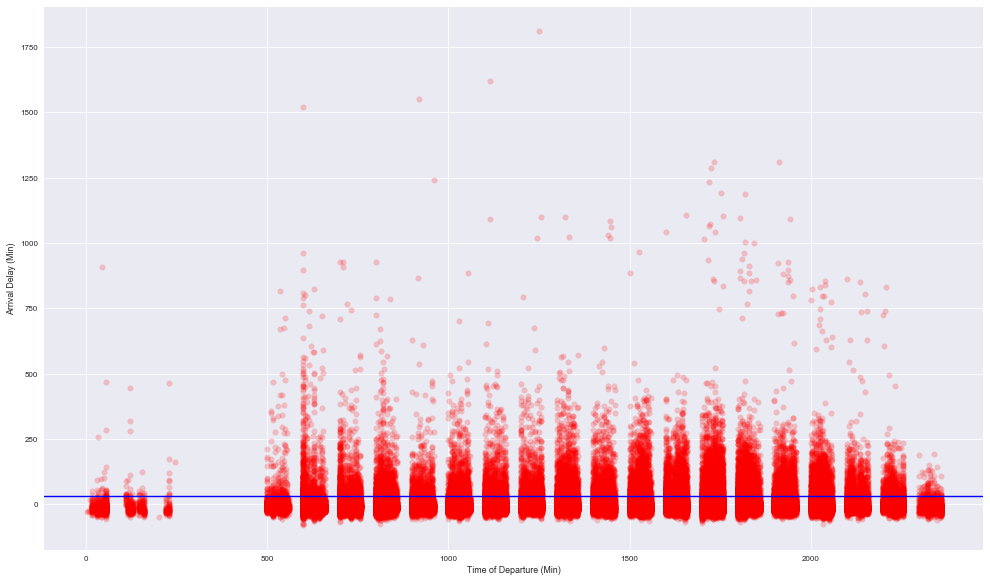

In [45]:
df = pd.read_csv('combined_data.csv',sep='\t')
plt.figure(figsize=(15,10))
plt.ylabel('Arrival Delay (Min)')
plt.xlabel('Time of Departure (Min)')
plt.scatter(df['CRS_DEP_TIME'].values, df['ARR_DELAY'].values, alpha=0.2 , c='r')
plt.axhline(y=30, color='b', linestyle='-')
plt.show()

<a id='parameters_tuning'></a>
## 5. Parameters tuning with Cross Validation and Grid Search
From the result above, we can see that Xgboost,knn and Random Forest are all behave well in predicting the delay of the flight and the mean absolute error for these three model are small. In this section, we want to tune our parameters in order to find the best parameters and get a better result compared to the former models. Therefore, we use the Grid Search method to test each parameters' combination and choose the best one for these three models.

In [40]:
xgb_model_1 = xgboost.XGBRegressor()
parameters = {'learning_rate': [0.05, 0.08, 0.1], 'max_depth': [ 5, 6],'n_estimators':[100,120,150,180]}
xgb_cv = GridSearchCV(xgb_model_1, parameters, verbose=True)#scoring='roc_auc',
xgb_cv.fit(X_train,y_train)
print(xgb_cv.best_score_)
print(xgb_cv.best_params_)
xgb_cv_prediction = xgb_cv.predict(X_test)
xgb_error=mean_absolute_error(xgb_cv_prediction,y_test)
print(xgb_error)
print(xgb_cv_prediction)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 17.7min finished


0.9588053185778871
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 180}
6.702551777129275
[-14.025687  -8.982468  -9.547613 ...  -7.946389  -9.368973 -14.9477  ]


In [41]:
knn_model_1 = neighbors.KNeighborsRegressor(n_jobs=3)
parameters = {'n_neighbors': [2,3,4,5,6,7,8]}
knn_cv = GridSearchCV(knn_model_1, parameters, verbose=True)
knn_cv.fit(X_train,y_train)
print(knn_cv.best_score_)
print(knn_cv.best_params_)
knn_cv_prediction = knn_cv.predict(X_test)
knn_error=mean_absolute_error(knn_cv_prediction,y_test)
print(knn_error)
print(knn_cv_prediction)
print(y_test)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   17.0s finished


0.9318142144999012
{'n_neighbors': 4}
8.142456783656364
[ -9.25  -5.25 -15.5  ...  -0.75 -12.25 -19.25]
[  5.  -8. -19. ...  -4. -10. -20.]


In [42]:
randomforest_model =ensemble.RandomForestRegressor(criterion='mae')
rf_model_1 = ensemble.RandomForestRegressor(n_estimators=100)
parameters = {'n_estimators': [80,100,120,150,200],'max_depth':[8,10,12]}
rf_model_cv = GridSearchCV(rf_model_1, parameters, verbose=True)
rf_model_cv.fit(X_train,y_train)
print(rf_model_cv.best_score_)
print(rf_model_cv.best_params_)
rf_model_cv_prediction = rf_model_cv.predict(X_test)
rf_error=mean_absolute_error(rf_model_cv_prediction,y_test)
print(rf_error)
print(rf_model_cv_prediction)
print(y_test)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 23.3min finished


0.9563420690784565
{'max_depth': 12, 'n_estimators': 200}
6.774503375277943
[-14.14796115  -9.05497682 -10.38299851 ...  -8.82858889  -9.34987935
 -13.75844481]
[  5.  -8. -19. ...  -4. -10. -20.]


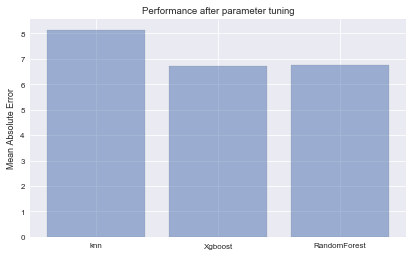

In [43]:
cv_models = ('knn','Xgboost','RandomForest')
y_pos = np.arange(len(cv_models))
cv_mean_absolute_errors=[knn_error,xgb_error,rf_error]
 
plt.bar(y_pos, cv_mean_absolute_errors, align='center', alpha=0.5)
plt.xticks(y_pos, cv_models)
plt.ylabel('Mean Absolute Error')
plt.title('Performance after parameter tuning')
 
plt.show()

<a id='conclusion'></a>
## 6. Conclusion
As for serious delay predict problem. Since we assumed that the delay above 30 minutes is large delay, i.e., serious delay, we chose the variable 'DELAY_APPEAR' as the variable to be predicted. In that case, we could predict whether the delay would be serious delay or not because serious delays would definitely affect both airport and passengers.
In this project, we do our job with a full data science pipeline and build a prediction model to predict the delay of the flights. From the result above, we can see that most of our regression models above could make a very accurate prediction in flight delay. In these models, Xgboost is the best one in prediction and has the lowest mean absolute error. Besides, knn is the fastest one for training, it only take several seconds to train a knn model and get a good result for our prediction.  
In conclusion, our models behave well in prdicting the delay of the flight and Xgboost Regression model could get a very small mean absolute error which is about 6.72 minutes. The prediction error is very small and we think it is accurate enough to predict the delay of the flight and could provide some usefull and precise information to the travelers.

<a id='future_work'></a>
## 7. Future work
There are still a lot of work we need to do to improve the performance of our prediction models.  
Firstly, we could expand our dataset and include more data from several recent years and find some relation between the month and the filght delay. This is a very important factor and different seasons or months will have different influence to the flight delay. In this case, broad our dataset will help us exploring the relation between them.  
Secondly, we could add more features to the models in order to enhance its robustness and precision. For example, add some traveler number information.
Thirdly, in order to increase the generalization of our models, we could use not only one province, but also explore more provinces and try to build a more gerneral and robust model to solve the prediction problem.  


<a id='reference'></a>
## 8. Reference

http://www.nycaviation.com/2014/06/delayed-air-traffic-control-delay-programs-work/34206  
https://www.bts.gov/  
http://scikit-learn.org/stable/  